`Задание`
`Основные цели этого задания:`

- Научиться понижать размерность данных

- Попрактиковаться в обучении моделей кластеризации

`Задача: по замерам акселерометра и гироскопа, произведенным с помощью телефона, находящегося на поясе, научиться отделять различные типы активностей друг от друга.`

`План решения:`

1. Загрузите данные из источника по ссылке. Нам нужен файл X_train.txt (там будет чуть более 7 тысяч наблюдений). Чтобы подгрузить этот файл, можно воспользоваться функцией loadtxt библиотеки numpy.

2. Ознакомьтесь с данными:

- выведите количество признаков;

- есть ли в данных пропуски;

- отличаются ли различные признаки по масштабу.

3. Понизьте размерность данных:

- воспользуйтесь методом порога отклонения, чтобы избавиться от наблюдений, вариативность по которым низка. Удалите не более 10 % признаков;

4. воспользуйтесь методом PCA:

- приведите признаки к одинаковому масштабу,

- визуализируйте зависимость степени объяснения дисперсии исходных данных от количества выделяемых главных компонент,

- определите минимальное необходимое количество главных компонент,  при которых объяснение дисперсии исходных данных будет достаточно велико (хотя бы 90 %),

- выделите первые две главные компоненты и с помощью визуализации убедитесь, что новые признаки позволяют неплохо отделить данные друг от друга.

5. Подберите оптимальное число кластеров: 

- воспользуйтесь методом локтя, чтобы оценить, как варьируется значение целевой функции кластеризации в зависимости от количества кластеров, на которые мы делим данные;

- выберите оптимальное количество кластеров и объясните свой выбор;

- повторите визуализацию данных по первым двум главным компонентам, размечая наблюдения каждого кластера своим цветом.

6. Оцените качество кластеризации:

- подгрузите реальные метки наблюдений из файла y_train.txt, а также их значения из файла activity_labels.txt;

- определите, насколько логична полученная кластеризация. Можно, например, сформировать сводную таблицу, где в строках будут реальные активности, а в столбцах — лейблы, полученные согласно кластеризации;

`сделайте выводы, опишите, почему те или иные виды активности могли объединиться в один кластер, а другие отделиться от них.`

-----------------

In [19]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

`1. Загрузите данные из источника по ссылке. Нам нужен файл X_train.txt (там будет чуть более 7 тысяч наблюдений). Чтобы подгрузить этот файл, можно воспользоваться функцией loadtxt библиотеки numpy.`

In [4]:
features = np.loadtxt('X_train.txt')

------------
`2. Ознакомьтесь с данными:`

- выведите количество признаков;

- есть ли в данных пропуски;

- отличаются ли различные признаки по масштабу.

- выведите количество признаков;

In [7]:
features.shape

(7352, 561)

- получился объект с типом numpy.ndarray размерностью 561 фича (столбец) и 7352 наблюдения (строка)

Создадим из него датафрейм. Проведем работу над ним

In [15]:
df = pd.DataFrame(features)

In [16]:
print(f'Количество дубликатов в DataFrame = {df.duplicated().sum()}')

Количество дубликатов в DataFrame = 0


- есть ли в данных пропуски;

In [17]:
print(f'    Количество NaN в DataFrame \n{"-"*50}\n{df.isna().sum()}')

    Количество NaN в DataFrame 
--------------------------------------------------
0      0
1      0
2      0
3      0
4      0
      ..
556    0
557    0
558    0
559    0
560    0
Length: 561, dtype: int64


пропуски в данных отсутствуют

In [20]:
df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118


In [21]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,...,0.125293,-0.307009,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,...,0.250994,0.321011,0.307584,0.336787,0.448306,0.608303,0.477975,0.511807,0.297480,0.279122
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.999873,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-0.995357,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.262975,-0.024863,-0.120993,-0.992754,-0.978129,-0.980233,-0.993591,-0.978162,-0.980251,-0.936219,...,-0.023692,-0.542602,-0.845573,-0.121527,-0.289549,-0.482273,-0.376341,-0.812065,-0.017885,-0.143414
50%,0.277193,-0.017219,-0.108676,-0.946196,-0.851897,-0.859365,-0.950709,-0.857328,-0.857143,-0.881637,...,0.134000,-0.343685,-0.711692,0.009509,0.008943,0.008735,-0.000368,-0.709417,0.182071,0.003181
75%,0.288461,-0.010783,-0.097794,-0.242813,-0.034231,-0.262415,-0.292680,-0.066701,-0.265671,-0.017129,...,0.289096,-0.126979,-0.503878,0.150865,0.292861,0.506187,0.359368,-0.509079,0.248353,0.107659
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,1.000000,0.478157,1.000000


- данные имеют значения от 1 до -1 


- проведем визуальный анализ данных на точечной диаграмме

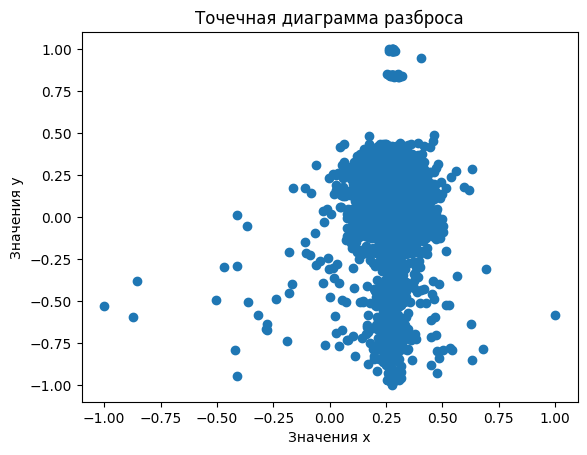

In [38]:
plt.scatter(df[0], df[560])
plt.title('Точечная диаграмма разброса')
plt.xlabel('Значения x')
plt.ylabel('Значения y')
plt.show()

- отличаются ли различные признаки по масштабу.

Построим гистограмму распределения средних значений по всем столбцам в датафрейме

<Axes: >

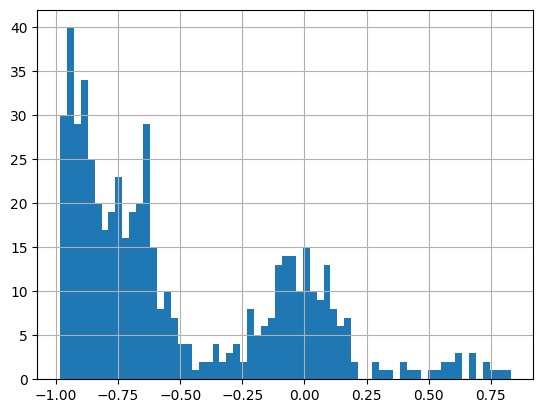

In [78]:
df.mean().hist(bins=65)

<Axes: >

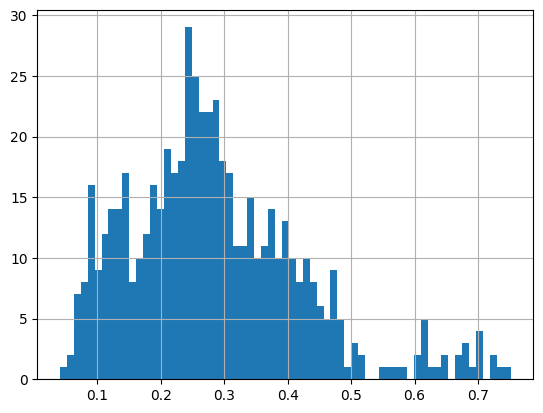

In [79]:
df.std().hist(bins=65)

видим, что распределение многовершинное (не нормальное). Признаки разные по масштабу. Требуется проводить стандартизацию (нормализацию) фичей.
далее будем применять метод StandardScaler

------------
`3. Понизьте размерность данных:`

- воспользуйтесь методом порога отклонения, чтобы избавиться от наблюдений, вариативность по которым низка. Удалите не более 10 % признаков;

In [62]:
features.shape

(7352, 561)

In [70]:
# Задаем порог отклонения (variance threshold)
threshold = 0.011

# Создаем объект VarianceThreshold и применяем его к данным
selector = VarianceThreshold(threshold)

# оценивает дисперсию (вариативность) каждого признака в матрице признаков features
# fit_transform сначала выполняет подгонку модели к данным, вычисляя необходимые статистические значения (например, дисперсию), 
# а затем преобразует данные путем удаления невыбранных признаков и возвращения новой матрицы признаков.
features2 = selector.fit_transform(features)
features2.shape

(7352, 520)

---------------
`4. воспользуйтесь методом PCA:`

- приведите признаки к одинаковому масштабу,

- визуализируйте зависимость степени объяснения дисперсии исходных данных от количества выделяемых главных компонент,

- определите минимальное необходимое количество главных компонент,  при которых объяснение дисперсии исходных данных будет достаточно велико (хотя бы 90 %),

- выделите первые две главные компоненты и с помощью визуализации убедитесь, что новые признаки позволяют неплохо отделить данные друг от друга.

Масштабируем фичи

In [123]:
features2_scaled = StandardScaler().fit_transform(features2)

Проведем анализ главных компонент (PCA) на наборе масштабированных Фичей. Построим график визуализации объясненной дисперсии с использованием PCA.

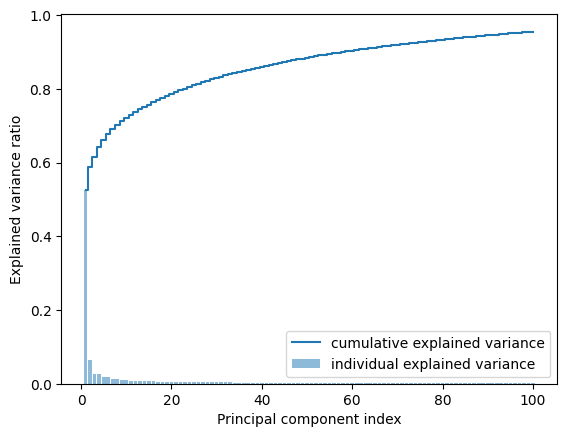

CPU times: total: 1.45 s
Wall time: 489 ms


In [99]:
# %%time
n_comp = 100  # Количество компонентов PCA
pca = PCA(n_components = n_comp)  # Создание объекта PCA с указанным количеством компонентов
pca.fit(features2_scaled)  # Применение PCA к стандартизованным данным

var_exp = pca.explained_variance_ratio_  # Вычисление объясненной дисперсии для каждой компоненты
cum_var_exp = np.cumsum(var_exp)  # Вычисление накопленной объясненной дисперсии

# Построение графика объясненной дисперсии
plt.bar(range(1, n_comp+1), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1, n_comp+1), cum_var_exp, where ='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

- найдем количество требуемых главных компонент если нам надо объяснить 90% дисперсии. (т.е. индекс минимального значения, превышающего порог 0.9.)

In [102]:
# создаем объект Series из массива с накопленной объясненной дисперсией, полученной из PCA`cum_var_exp`
# создадим булевую серию с условием cum_var_exp > 0.9
# с помощью .index.min() возвратим индекс минимального значения в выбранных значениях


n_comps_explane = pd.Series(cum_var_exp)[pd.Series(cum_var_exp)> 0.9].index.min()
n_comps_explane

57

- Можно найти (выделить) 57 главных компонент и это объяснит 90% дисперсии от входных данных.

In [103]:
first2_components = PCA(n_components=2).fit_transform(features2_scaled)

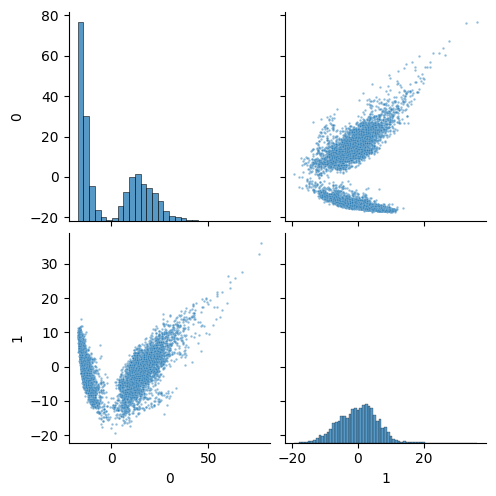

In [104]:
sns.pairplot(pd.DataFrame(first2_components), plot_kws={'s': 3, 'alpha': 0.5})

- Можно сделать вывод о том, что данные хорошо делятся по 0й компоненте

--------

`5. Подберите оптимальное число кластеров: `

- воспользуйтесь методом локтя, чтобы оценить, как варьируется значение целевой функции кластеризации в зависимости от количества кластеров, на которые мы делим данные;

- выберите оптимальное количество кластеров и объясните свой выбор;

- повторите визуализацию данных по первым двум главным компонентам, размечая наблюдения каждого кластера своим цветом.

Выполним подбор оптимального количества кластеров

In [105]:
features_pca = PCA(n_components=57).fit_transform(features2_scaled)

  0%|          | 0/9 [00:00<?, ?it/s]c:\Users\Mi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
 11%|█         | 1/9 [00:00<00:02,  3.21it/s]c:\Users\Mi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Mi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
 33%|███▎   

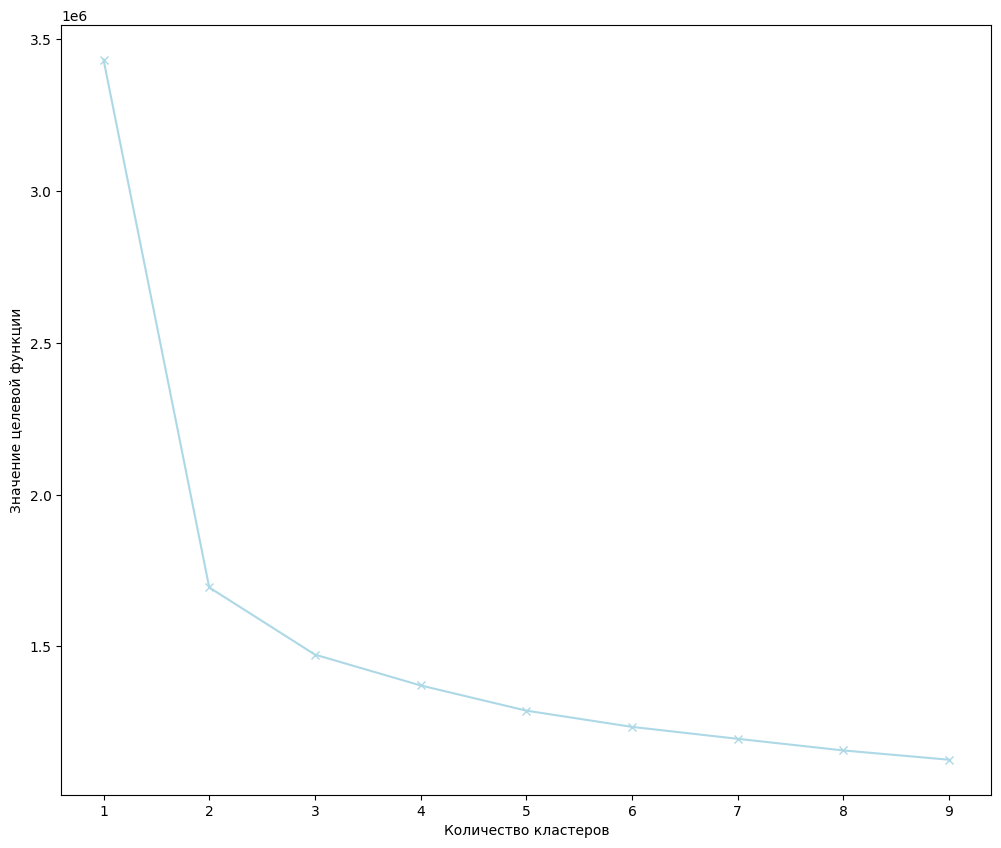

In [106]:
dist = []
K = range(1,10)

for k in tqdm(K):
    model = KMeans(n_clusters=k, random_state=45)
    model.fit(features_pca)
    dist.append(model.inertia_)

plt.figure(figsize=(12,10))
plt.plot(K, dist, c = 'lightblue', marker = 'x')
plt.xlabel('Количество кластеров')
plt.ylabel('Значение целевой функции')
plt.show()

- Видно, что после 3х кластеров уменьшение целевой функции не значительные. Выберем 3 кластера.

In [124]:
model = KMeans(n_clusters=3, random_state=45)
model.fit(features_pca)

c:\Users\Mi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3, random_state=45)

In [125]:
main_df = pd.DataFrame(first2_components)
main_df['target'] = model.labels_

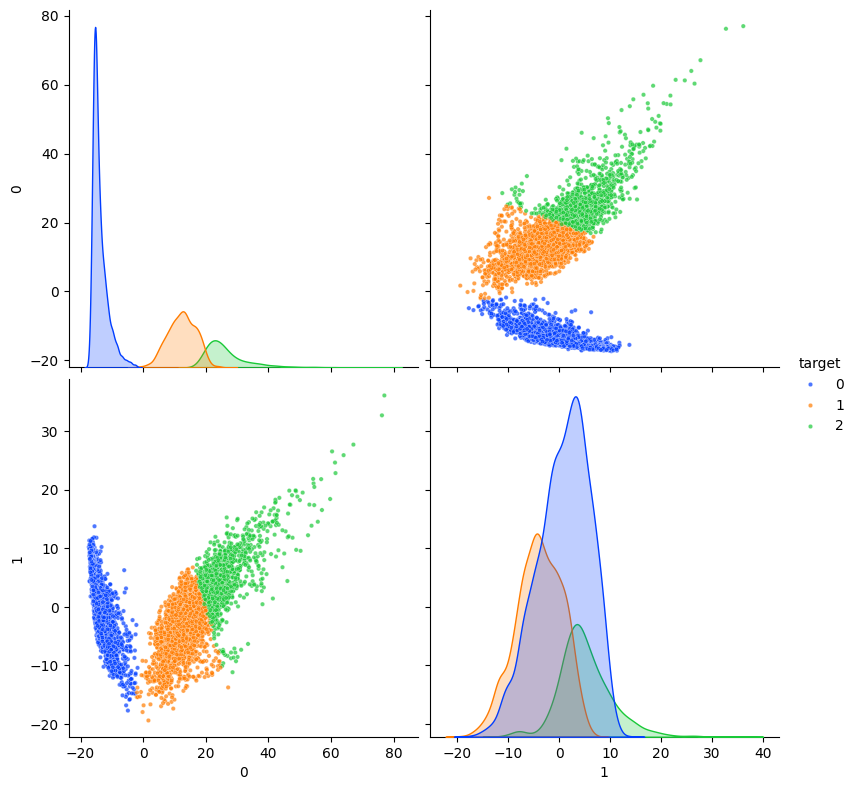

In [126]:
sns.pairplot(main_df, plot_kws={'s': 10, 'alpha': 0.7}, hue='target', palette='bright', height=4)

---------------------
`6. Оцените качество кластеризации:`

- подгрузите реальные метки наблюдений из файла y_train.txt, а также их значения из файла activity_labels.txt;

- определите, насколько логична полученная кластеризация. Можно, например, сформировать сводную таблицу, где в строках будут реальные активности, а в столбцах — лейблы, полученные согласно кластеризации;

- Произведем оценку качества выделения активностей, сопоставляя проставленные лейблы с реальными

In [127]:
real_target = pd.Series(np.loadtxt('y_train.txt')).astype('int')

In [128]:
activity_labels_map = dict(pd.read_csv('activity_labels.txt', sep=' ', header=None).set_index(0)[1])
activity_labels_map

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

In [129]:
main_df['real_target'] = real_target.map(activity_labels_map)

In [130]:
main_df.pivot_table(index='real_target', columns='target', values=0, aggfunc='count')

target,0,1,2
real_target,,,
LAYING,1391.0,16.0,NaN
SITTING,1283.0,3.0,NaN
STANDING,1373.0,1.0,NaN
WALKING,NaN,874.0,352.0
WALKING_DOWNSTAIRS,NaN,385.0,601.0
WALKING_UPSTAIRS,NaN,956.0,117.0


- в 0 кластер попали LAYING, SITTING и STANDING в других кластерах этих лыйблов по сути нет.

`ВЫВОД:`
 - активности LAYING, SITTING и STANDING похожи между собой отсутствием большого количества движений (то есть дополнительных данных в этих фичах).
в связи с этим их с такой точностью удалось кластеризовать (выделить из данных)
 - а вот  WALKING, WALKING_DOWNSTAIRS и WALKING_UPSTAIRS кластеризовалась крайне плохо. Хотя в 1й кластер с большей вероятностью попали WALKING_UPSTAIRS и WALKING,
`по всей видимости` в этих видах активности `больше` `активной` составляющей.
